In [88]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import seaborn as sns
import json

In [89]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'drive/MyDrive/Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # # interpolate bl_height by time
    # df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # # aggregate bl_height by hourly average
    # df = df.groupby([
    #     df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
    #     df['# Time'].dt.hour.rename('Hour')
    # ])['revised_bl_height'].mean().reset_index(name='CL_BLH')

    return df.set_index('# Time').interpolate(method='time').reset_index()

df = parse_CL('Lidcombe')
df

,# Time,Layer_QualityIndex,bl_height,Mean_Layer_Height,n_BL,cloud_stat,cloud_dat
0,2021-02-12 11:00:00,3.0,440.0,390.0,3,1,4880.0
1,2021-02-12 11:00:16,3.0,440.0,390.0,3,1,4850.0
2,2021-02-12 11:00:32,3.0,440.0,390.0,3,1,4850.0
3,2021-02-12 11:00:48,3.0,440.0,390.0,3,1,4600.0
4,2021-02-12 11:01:04,3.0,440.0,390.0,3,1,4600.0
...,...,...,...,...,...,...,...
37516,2021-02-16 10:58:40,1.0,1120.0,720.0,3,1,2050.0
37517,2021-02-16 10:58:56,1.0,1100.0,720.0,3,0,2040.0
37518,2021-02-16 10:59:12,1.0,1100.0,720.0,3,0,2030.0
37519,2021-02-16 10:59:28,1.0,1110.0,720.0,3,0,2020.0


The 'n_BL' column is all 3. Drop it.

In [90]:
df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'),
        df['# Time'].dt.hour.rename('Hour'),
        # df['# Time'].dt.minute.rename('Minute'),
    ]).mean().reset_index()


def df_column_switch(df, column1, column2):
  i = list(df.columns)
  a, b = i.index(column1), i.index(column2)
  i[b], i[a] = i[a], i[b]
  df = df[i]
  return df

df = df_column_switch(df, 'bl_height', 'cloud_dat')
df = df.drop('n_BL', 1).iloc[:,2:]
df

,Layer_QualityIndex,cloud_dat,Mean_Layer_Height,cloud_stat,bl_height
0,3.000000,6196.755556,390.000000,1.462222,1474.222222
1,2.000000,5745.911111,460.000000,1.097778,1826.222222
2,2.000000,5660.977778,1690.000000,1.173333,1662.444444
3,2.000000,6411.494726,1640.000000,0.280000,1500.755556
4,3.000000,5344.949718,1610.000000,0.515556,1546.844444
...,...,...,...,...,...
163,2.000000,894.977778,730.000000,1.506667,1094.350000
164,1.004444,1385.333333,471.155556,1.626667,616.111111
165,1.000000,1241.733333,620.000000,1.884444,879.903145
166,1.000000,1221.096296,630.000000,1.284444,889.407966


In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = scaler.fit_transform(df.values.astype('float32'))
dataset

array([[1.        , 0.96541333, 0.13688213, 0.73273945, 0.64794683],
       [0.5       , 0.89279884, 0.1634981 , 0.55011135, 0.81664306],
       [0.5       , 0.87911916, 0.6311787 , 0.58797324, 0.7381525 ],
       [0.5       , 0.99999994, 0.6121673 , 0.1403118 , 0.660663  ],
       [1.        , 0.8282187 , 0.60076046, 0.2583519 , 0.6827511 ],
       [0.5022222 , 0.82575357, 0.5704774 , 0.518931  , 0.71561706],
       [0.9977778 , 0.8317738 , 0.5930545 , 0.39643654, 0.92944807],
       [0.5       , 0.74528635, 0.94676805, 0.53897554, 0.95268637],
       [0.        , 0.4673198 , 0.8555133 , 0.6703786 , 0.6725605 ],
       [0.5       , 0.32238424, 0.03041825, 0.7082405 , 0.538442  ],
       [1.        , 0.38327336, 0.03041825, 0.95545655, 0.05629598],
       [0.5       , 0.37723887, 0.11026616, 0.8084633 , 0.13354865],
       [0.5       , 0.14616674, 0.10646387, 0.73719376, 0.07219899],
       [0.5       , 0.12352481, 0.03802281, 0.74832964, 0.01484612],
       [0.5       , 0.30081612, 0.

In [92]:
from keras.models import Sequential
from keras.layers import *

train_size = int(len(dataset) * 0.75)

# Univariate

Predict the pattern:
```
Given: [10, 20, 30, 40, 50, 60, 70, 80, 90]
```
```
[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90
```

In [93]:
def univariate_split(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x, seq_y = sequence[i:end_ix,-1], sequence[end_ix,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [94]:
'''
Function: Calculates and prints out the varoius metrics
'''
from sklearn.metrics import mean_absolute_error, mean_squared_error

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia


from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def satistical_comps(y_true, y_pred, title):    
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  mbe = np.mean(y_pred - y_true)
  ioa = index_agreement(y_pred, y_true)
  dtw_dist, path = fastdtw(y_true, y_pred, dist=euclidean)
  
  print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f' % (title, ioa, rmse, mae, mbe, dtw_dist))


In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (17, 6)


def pred_plots(y_true, y_pred, title):
  df = pd.DataFrame({
    'Real': y_true,
    'Predict': y_pred
  })
  resid_plot_title = 'Residual plot ' + title
  pred_plot_title = 'Predict vs. Real ' + title
  
  sns.set_theme(style="whitegrid")

  # Plot the residuals after fitting a linear model
  ax1 = plt.subplot(121)
  sns.residplot(x='Real', y='Predict', data=df, lowess=True, color="g", ax=ax1).set(title = resid_plot_title)
  ax2 = plt.subplot(122)
  df.plot(title = pred_plot_title, ax=ax2)
  plt.show()
  
  satistical_comps(y_true, y_pred, title)


#### Vanilla LSTM

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


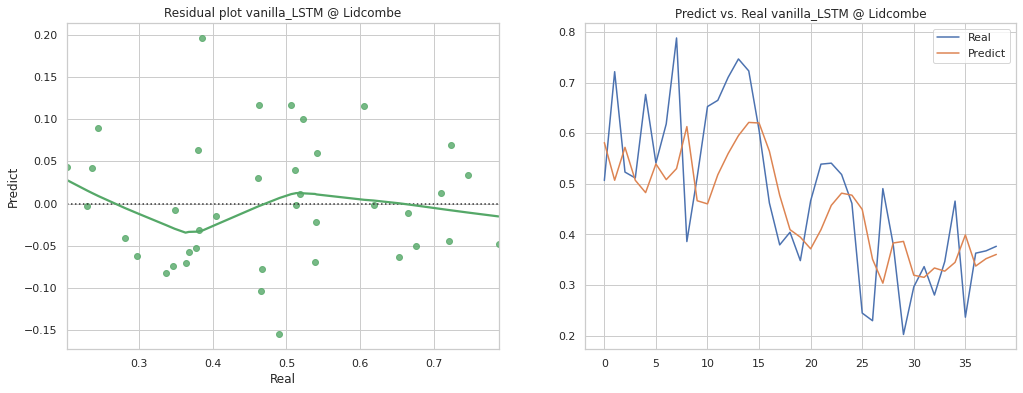

At vanilla_LSTM @ Lidcombe
Index of agreement:0.74026
Root mean squared error:0.12050
Mean absoluate error:0.09497
Mean bias error:-0.02402
DTW distance:2.27


In [96]:
def vanilla_LSTM():
  n_steps = 3
  n_features = 1
  X, y = univariate_split(dataset, n_steps)
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=200, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'vanilla_LSTM @ Lidcombe')

vanilla_LSTM()


#### CNN LSTM

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


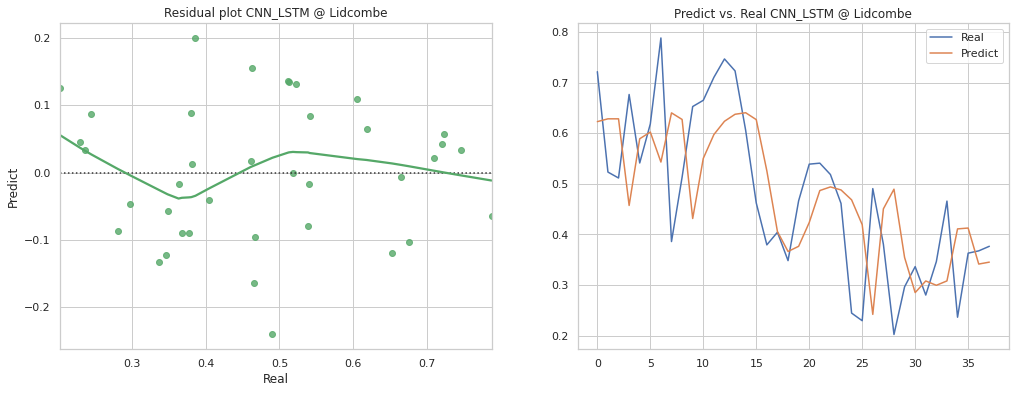

At CNN_LSTM @ Lidcombe
Index of agreement:0.71559
Root mean squared error:0.13555
Mean absoluate error:0.11025
Mean bias error:0.00073
DTW distance:2.03


In [97]:
def CNN_LSTM():
  n_steps = 4
  X, y = univariate_split(dataset, n_steps)

  n_features = 1
  n_seq = 2
  n_steps = 2
  X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=500, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'CNN_LSTM @ Lidcombe')

CNN_LSTM()


#### Conv LSTM

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


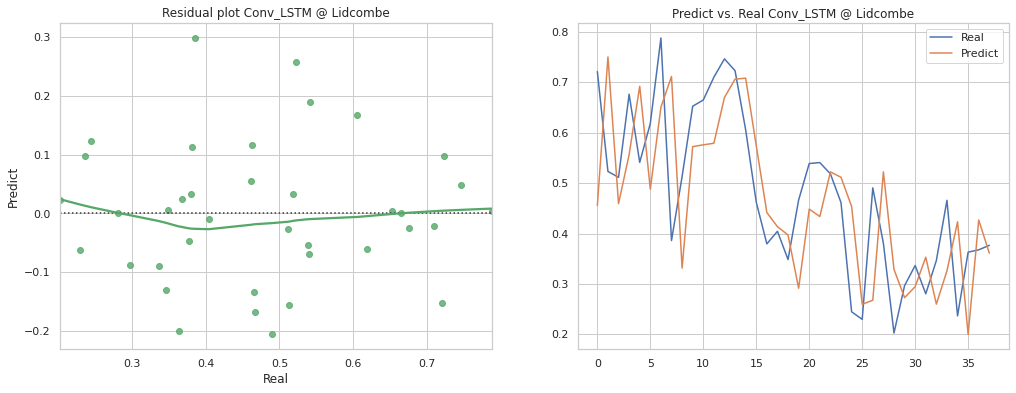

At Conv_LSTM @ Lidcombe
Index of agreement:0.77617
Root mean squared error:0.13443
Mean absoluate error:0.11220
Mean bias error:-0.01130
DTW distance:1.58


In [98]:
def Conv_LSTM():
  n_steps = 4
  X, y = univariate_split(dataset, n_steps)

  n_features = 1
  n_seq = 2
  n_steps = 2
  X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=500, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'Conv_LSTM @ Lidcombe')

Conv_LSTM()

# Multivariate

Predict the pattern:
```
Given: 
[
  [ 10  15  25]
  [ 20  25  45]
  [ 30  35  65]
  [ 40  45  85]
  [ 50  55  105]
  [ 60  65  125]
  [ 70  75  145]
  [ 80  85  165]
  [ 90  95  185]
]
```
```
[
  [10, 15]
  [20, 25]
  [30, 35]
] 
-> [85]
```

In [99]:
def multivariate_split(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

#### Vanilla LSTM

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 50)                11000     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


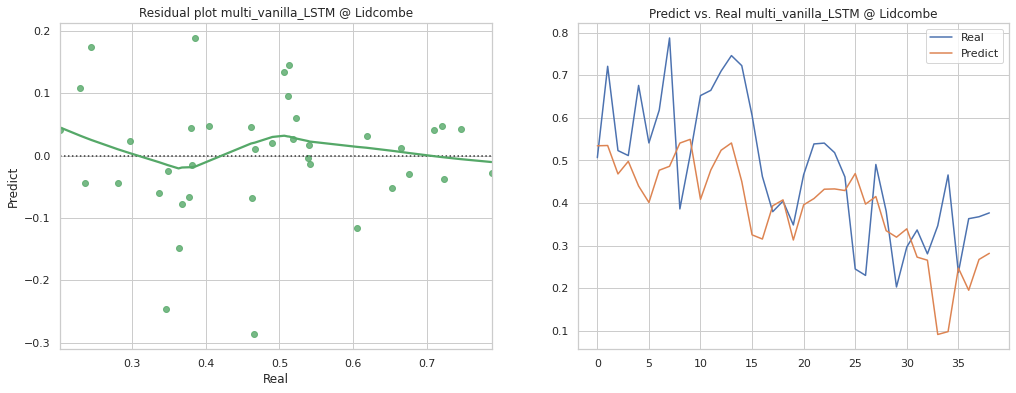

At multi_vanilla_LSTM @ Lidcombe
Index of agreement:0.64386
Root mean squared error:0.15963
Mean absoluate error:0.12929
Mean bias error:-0.08837
DTW distance:3.71


In [100]:
def multi_vanilla_LSTM():
  n_steps = 3
  X, y = multivariate_split(dataset, n_steps)
  n_features = X.shape[2]
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=200, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'multi_vanilla_LSTM @ Lidcombe')

multi_vanilla_LSTM()


#### CNN LSTM

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, None, 2, 64)       320       
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 23,371
Trainable params: 23,371
Non-trainable params: 0
_________________________________________________________________


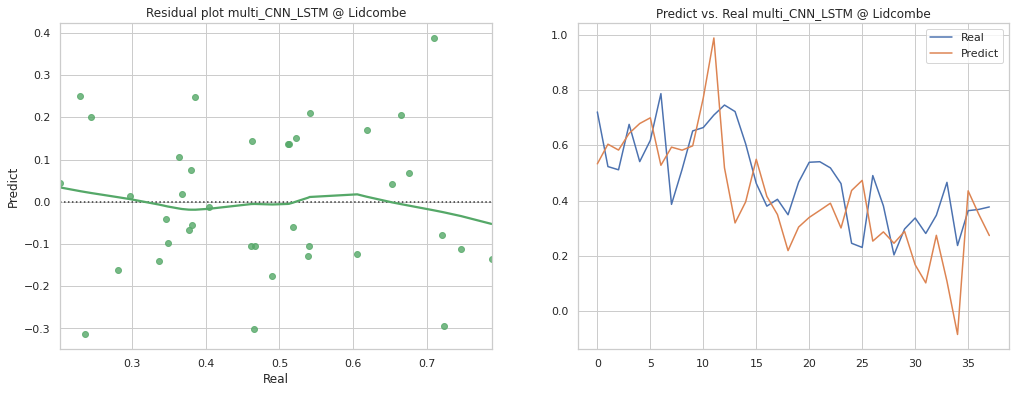

At multi_CNN_LSTM @ Lidcombe
Index of agreement:0.73621
Root mean squared error:0.17694
Mean absoluate error:0.14913
Mean bias error:-0.05915
DTW distance:3.57


In [101]:
def multi_CNN_LSTM():
  n_steps = 4
  X, y = multivariate_split(dataset, n_steps)

  n_features = X.shape[2]
  n_seq = 2
  n_steps = 2
  X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=500, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'multi_CNN_LSTM @ Lidcombe')

multi_CNN_LSTM()


#### Conv LSTM

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 1, 64)          35072     
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 35,137
Trainable params: 35,137
Non-trainable params: 0
_________________________________________________________________


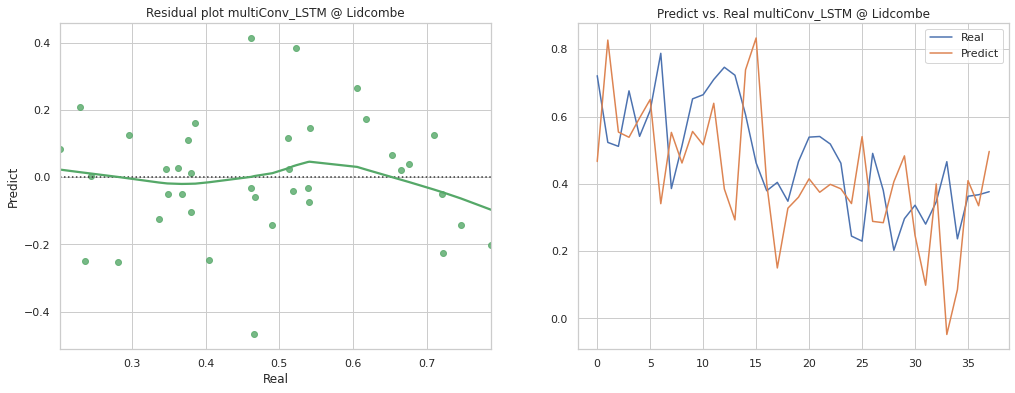

At multiConv_LSTM @ Lidcombe
Index of agreement:0.55810
Root mean squared error:0.20775
Mean absoluate error:0.16515
Mean bias error:-0.05235
DTW distance:4.33


In [102]:
def multi_Conv_LSTM():
  n_steps = 4
  X, y = multivariate_split(dataset, n_steps)

  n_features = X.shape[2]
  n_seq = 2
  n_steps = 2
  X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=500, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:], y_pred, 'multiConv_LSTM @ Lidcombe')

multi_Conv_LSTM()

# Multi-step Forecasting

Predict the pattern:
```
Given: [10, 20, 30, 40, 50, 60, 70, 80, 90]
```
```
[10 20 30] -> [40, 50]

```

In [103]:
def multi_step_split(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence) - n_steps_in - n_steps_out):
    end_ix = i + n_steps_in
    seq_x, seq_y = sequence[i:end_ix,-1], sequence[end_ix:end_ix+n_steps_out,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

#### Vector Output Model

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 5, 100)            40800     
_________________________________________________________________
lstm_43 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________


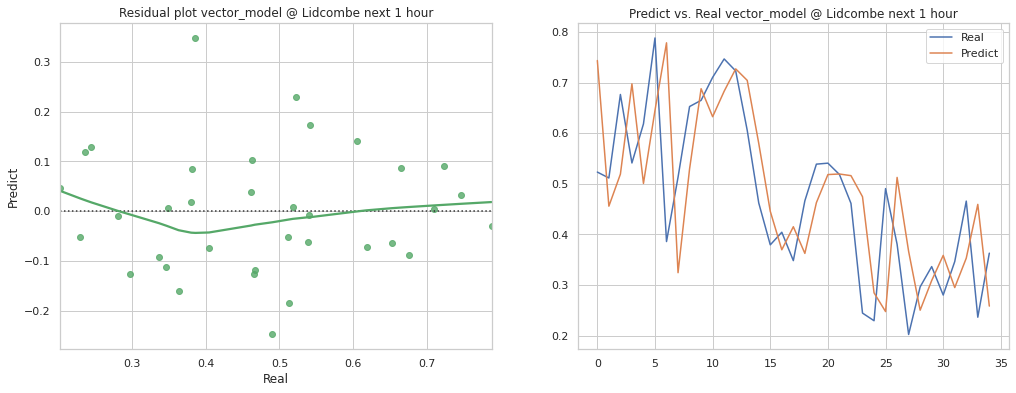

At vector_model @ Lidcombe next 1 hour
Index of agreement:0.77769
Root mean squared error:0.13604
Mean absoluate error:0.10944
Mean bias error:0.00955
DTW distance:1.06


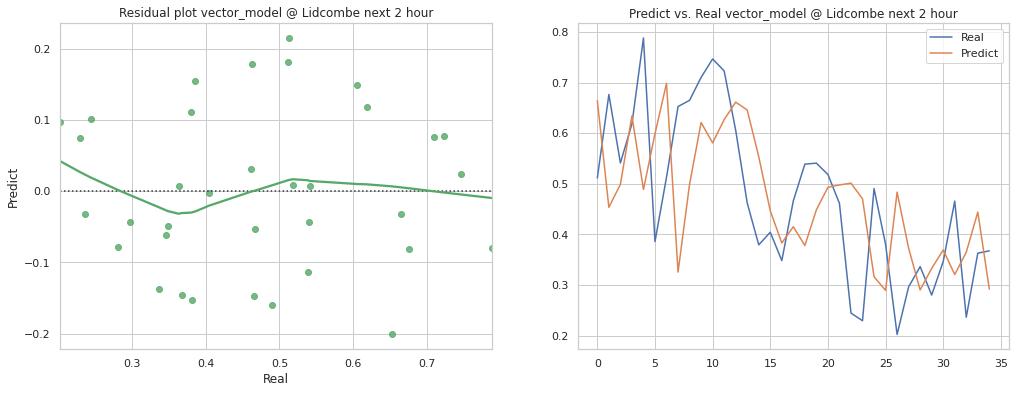

At vector_model @ Lidcombe next 2 hour
Index of agreement:0.62193
Root mean squared error:0.15435
Mean absoluate error:0.12857
Mean bias error:-0.00101
DTW distance:1.65


In [104]:
def vector_model():
  n_steps_in, n_steps_out = 5, 2
  X, y = multi_step_split(dataset, n_steps_in, n_steps_out)
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  model = Sequential()
  model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(100, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=200, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:,0], y_pred[:,0], 'vector_model @ Lidcombe next 1 hour')
  pred_plots(y[train_size:,1], y_pred[:,1], 'vector_model @ Lidcombe next 2 hour')

vector_model()

#### Encoder-Decoder Model

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 100)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 2, 100)            80400     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 2, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


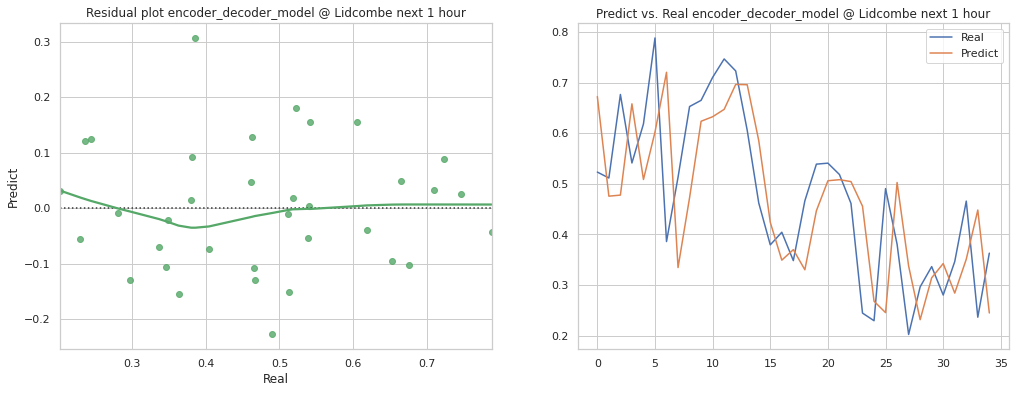

At encoder_decoder_model @ Lidcombe next 1 hour
Index of agreement:0.78146
Root mean squared error:0.13089
Mean absoluate error:0.10831
Mean bias error:-0.01103
DTW distance:1.15


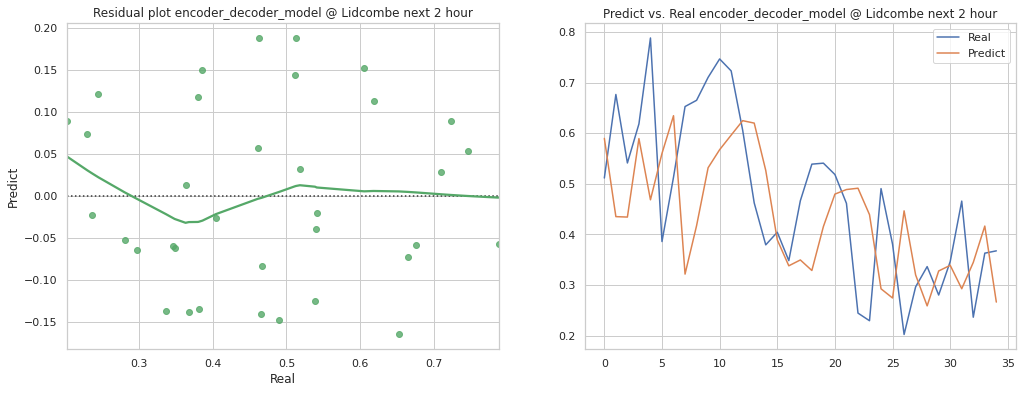

At encoder_decoder_model @ Lidcombe next 2 hour
Index of agreement:0.60397
Root mean squared error:0.15812
Mean absoluate error:0.13127
Mean bias error:-0.03659
DTW distance:2.07


In [105]:
def encoder_decoder_model():
  n_steps_in, n_steps_out = 5, 2
  X, y = multi_step_split(dataset, n_steps_in, n_steps_out)
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  
  # fit model
  model.fit(X[:train_size], y[:train_size], epochs=200, verbose=0)
  # predict
  y_pred = model.predict(X[train_size:]).squeeze()
  # plot
  pred_plots(y[train_size:,0], y_pred[:,0], 'encoder_decoder_model @ Lidcombe next 1 hour')
  pred_plots(y[train_size:,1], y_pred[:,1], 'encoder_decoder_model @ Lidcombe next 2 hour')

encoder_decoder_model()

# <s>Deprecated


The following demonstrate how to predict BLH by only consider itself using pytorch.</s>

In [40]:
def create_dataset(dataset, look_back=48):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

feature_size = 24
data_X, data_Y = create_dataset(dataset, feature_size)

In [42]:
print(data_X.shape) 
print(data_Y.shape)

(144, 24, 6)
(144, 6)


In [43]:
train_size = int(len(data_X) * 0.75)

train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [9]:
# (seq length, batch size, feature size)
train_X = train_X.reshape(-1, 1, feature_size)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, feature_size)
test_Y = test_Y.reshape(-1, 1, 1)

In [10]:
import torch

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_x = torch.from_numpy(train_X).to(device)
train_y = torch.from_numpy(train_Y).to(device)
test_x = torch.from_numpy(test_X).to(device)
test_y = torch.from_numpy(test_Y).to(device)

In [12]:
from torch import nn

In [13]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.clf = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = self.clf(x.view(-1, h))
        return x.view(s, b, -1)

In [16]:
net = lstm(feature_size, 20).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [17]:
for e in range(100):
    optimizer.zero_grad()

    out = net(train_x)
    loss = criterion(out, train_y)
    
    loss.backward()
    optimizer.step()
    if (e + 1) % 5 == 0:
        with torch.no_grad():
            pred_test = net(test_x)
            # pred_test = pred_test.numpy().squeeze(2)
            print(f'Epoch: {e + 1}, Loss: {loss.item():.5f}, Actual: {criterion(pred_test, test_y).item():.5f}')

Epoch: 5, Loss: 0.03325, Actual: 0.03300
Epoch: 10, Loss: 0.03306, Actual: 0.03809
Epoch: 15, Loss: 0.03148, Actual: 0.02821
Epoch: 20, Loss: 0.02991, Actual: 0.03378
Epoch: 25, Loss: 0.02951, Actual: 0.03233
Epoch: 30, Loss: 0.02814, Actual: 0.02781
Epoch: 35, Loss: 0.02568, Actual: 0.03137
Epoch: 40, Loss: 0.02211, Actual: 0.03239
Epoch: 45, Loss: 0.02025, Actual: 0.02768
Epoch: 50, Loss: 0.01838, Actual: 0.02318
Epoch: 55, Loss: 0.01647, Actual: 0.02174
Epoch: 60, Loss: 0.01484, Actual: 0.01966
Epoch: 65, Loss: 0.01366, Actual: 0.02194
Epoch: 70, Loss: 0.01162, Actual: 0.02357
Epoch: 75, Loss: 0.01079, Actual: 0.02041
Epoch: 80, Loss: 0.00939, Actual: 0.02310
Epoch: 85, Loss: 0.00810, Actual: 0.01991
Epoch: 90, Loss: 0.00710, Actual: 0.02378
Epoch: 95, Loss: 0.00637, Actual: 0.02112
Epoch: 100, Loss: 0.00587, Actual: 0.02065


In [18]:
with torch.no_grad():
    pred_test = net(torch.from_numpy(data_X.reshape(-1,1,feature_size)).to(device))
    pred_test = pred_test.cpu().numpy().squeeze(2)

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

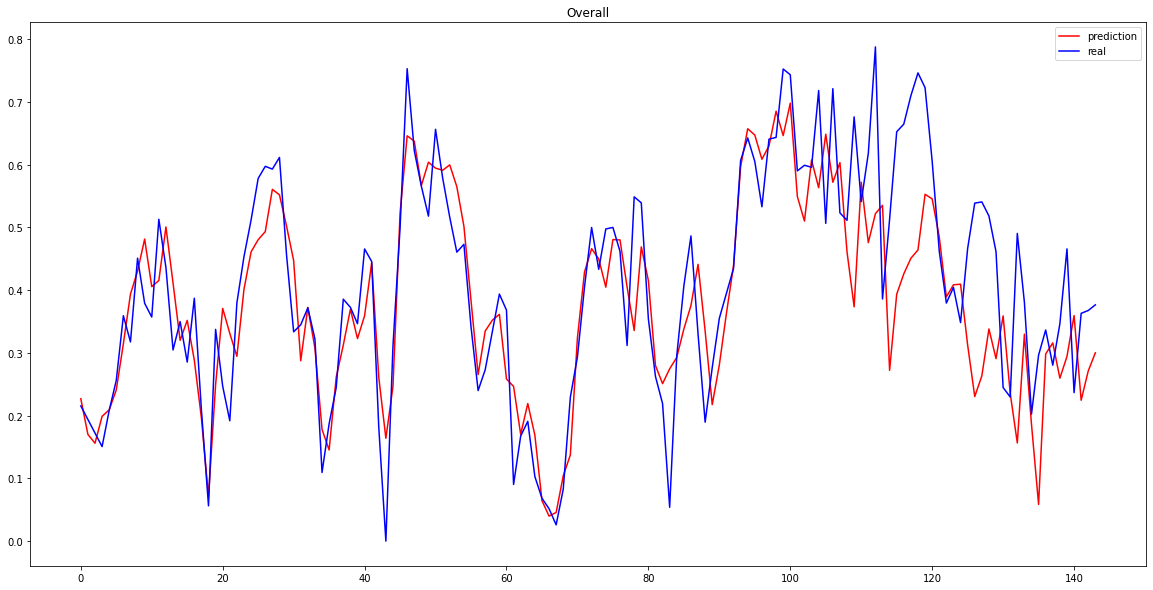

In [20]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_Y, 'b', label='real')
plt.legend()
plt.title('Overall')
plt.show()

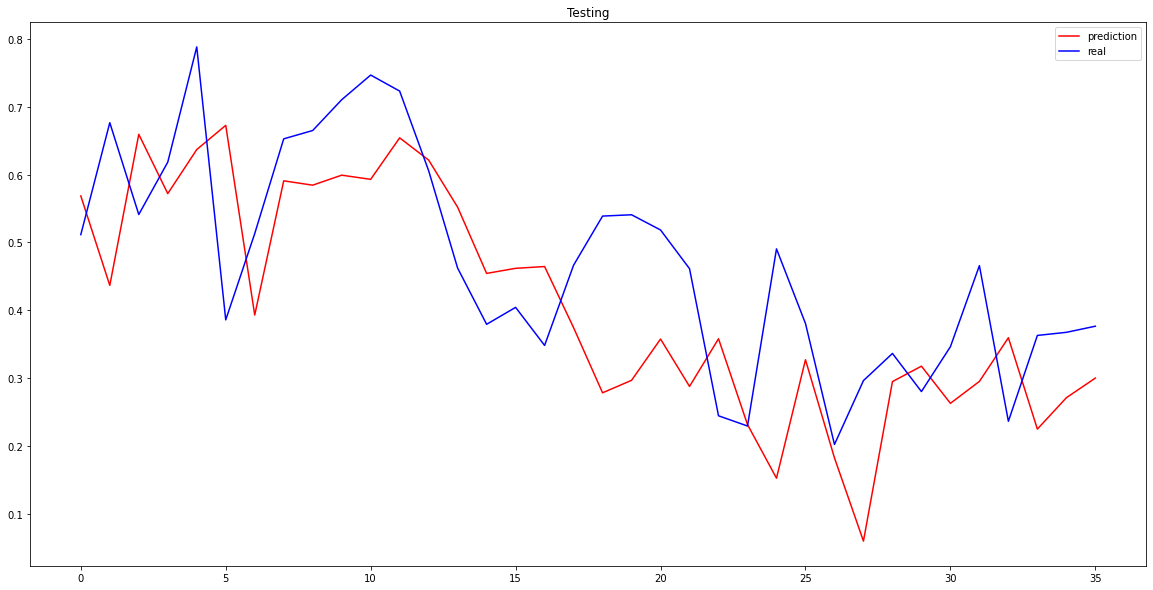

In [21]:
with torch.no_grad():
    pred_y = net(test_x).cpu().numpy().squeeze(2)

plt.plot(pred_y, 'r', label='prediction')
plt.plot(test_Y.squeeze(), 'b', label='real')
plt.legend()
plt.title('Testing')
plt.show()

In [24]:
# self predict
with torch.no_grad():
    self_pred_x = test_x[-1, 0].tolist()
    self_pred_y = []
    for i in range(len(test_y)):
        y_out = net(torch.FloatTensor(self_pred_x).reshape(1,1,-1).to(device))
        self_pred_y.extend(y_out.cpu().numpy())
        self_pred_x.append(y_out.squeeze().item())
        self_pred_x = self_pred_x[1:]
        # print(np.array(self_pred_y).squeeze(), self_pred_x[-5:])
        # break

In [ ]:
self_pred_x

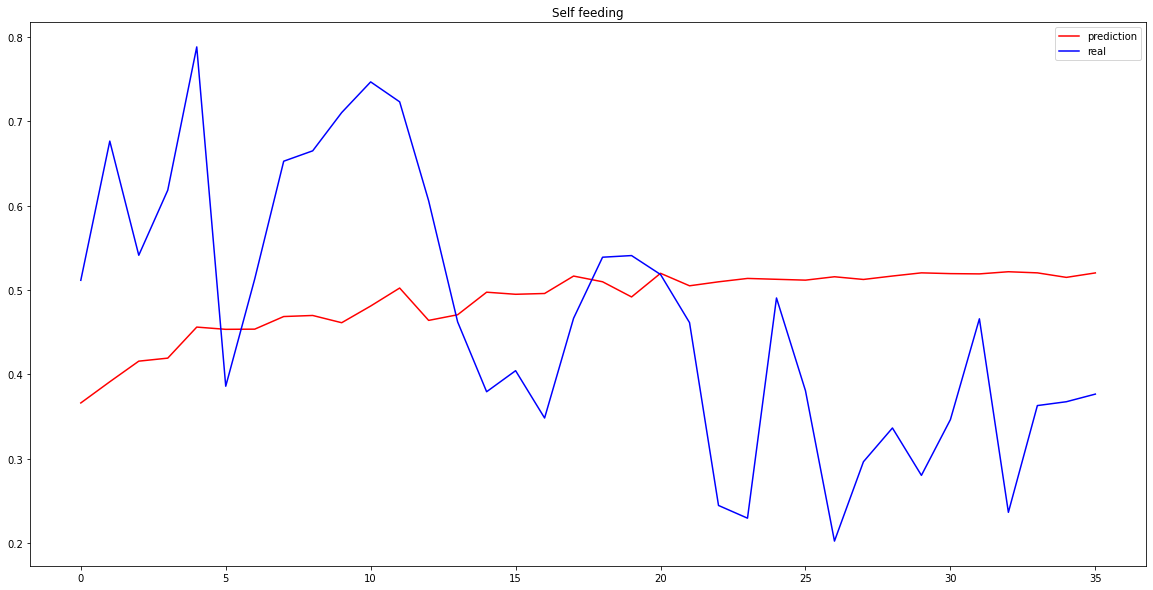

In [25]:
plt.plot(np.array(self_pred_y).squeeze(), 'r', label='prediction')
plt.plot(test_Y.squeeze(), 'b', label='real')
plt.legend()
plt.title('Self feeding')
plt.show()

TypeError: ignored